In [1]:
# Final robust alignment + EOF/PCA script (run step-by-step)
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import string


In [2]:
# List of month names
month_names = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]

wind_data = 'datasets/data_t.nc'
current_data = 'datasets/cmems_obs-mob_glo_phy-cur_my_0.25deg_P1M-m_1740187181287.nc'
ssh_data = 'datasets/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.125deg_P1D_1740483994742.nc'
sst_data = 'datasets/MUR_Monthly_SST_.nc'
sss_data = 'datasets/cmems_obs-mob_glo_phy-sss_my_multi_P1M_1740653508523.nc'


Explained variance ratio: [0.49936935 0.15106081 0.08858098 0.05036212 0.02693912]


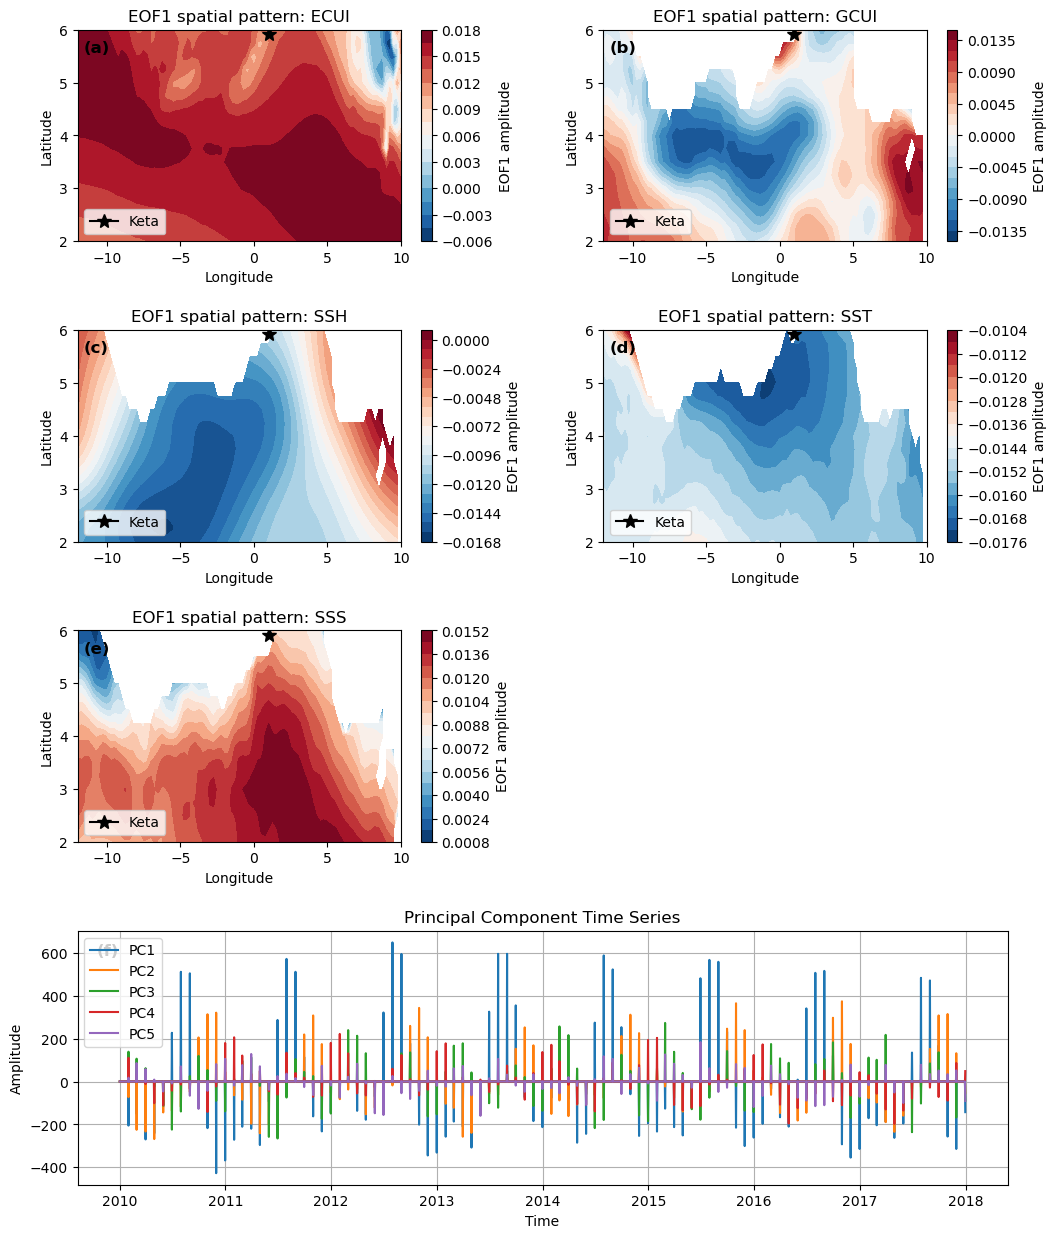

In [4]:
# PCA was done only in time, so the EOFs were really just weights across variables, not spatial patterns.

# Pros: simple, easy to see how the variables covary over time.

# Cons: loses all spatial information, so you can’t see where patterns occur


# -------------------------
# 1️⃣ Open datasets
# -------------------------
ssh_ds = xr.open_dataset(ssh_data)   # Adjust variable name as needed
sst_ds = xr.open_dataset(sst_data)
sss_ds = xr.open_dataset(sss_data)
# Example: ECUI/GCUI dataset
cui_ds = xr.open_dataset('datasets/CUI_2010_2017.nc')

# -------------------------
# 2️⃣ Subset to common time range
# -------------------------
time_range = slice("2010-01-01", "2017-12-31")

ssh_ds = ssh_ds.sel(time=time_range)
sst_ds = sst_ds.sel(time=time_range)
sss_ds = sss_ds.mean(dim='depth').sel(time=time_range)
cui_ds = cui_ds.sel(time=time_range)

# Extract key variables
ECUI = cui_ds['ECUI'] * 86400
GCUI = cui_ds['GCUI'] * 86400
SSH  = ssh_ds['adt']   # change if your variable name differs
SST  = sst_ds['sst']
SSS  = sss_ds['sos']

# -------------------------
# 3️⃣ Interpolate all datasets to common grid (CUI grid)
# -------------------------
def interp_to_cui(ds, cui_ds):
    return ds.interp(latitude=cui_ds.latitude, longitude=cui_ds.longitude, time=cui_ds.time)

SSH_i = interp_to_cui(SSH, cui_ds)
SST_i = interp_to_cui(SST, cui_ds)
SSS_i = interp_to_cui(SSS, cui_ds)

# -------------------------
# 4️⃣ Align coordinates
# -------------------------
def ensure_time_dim(da):
    if 'valid_time' in da.dims:
        da = da.rename({'valid_time': 'time'})
    return da

ECUI = ensure_time_dim(ECUI)
GCUI = ensure_time_dim(GCUI)
SSH_i = ensure_time_dim(SSH_i)
SST_i = ensure_time_dim(SST_i)
SSS_i = ensure_time_dim(SSS_i)

# -------------------------
# 5️⃣ Combine into a single xarray Dataset
# -------------------------
ds_combined = xr.Dataset({
    'ECUI': ECUI,
    'GCUI': GCUI,
    'SSH': SSH_i,
    'SST': SST_i,
    'SSS': SSS_i
})

# -------------------------
# 6️⃣ Subset to region (optional)
# -------------------------
# lat_range = slice(0.5, 6.0)
# lon_range = slice(0.0, 2.0)
lat_range = slice(2, 6.0)
ds_sub = ds_combined.sel(latitude=lat_range)

# -------------------------
# 7️⃣ Flatten: time x (variable * lat * lon)
# -------------------------
data = ds_sub.to_array().transpose("time", "variable", "latitude", "longitude").values
n_time, n_var, n_lat, n_lon = data.shape
X_flat = data.reshape(n_time, n_var * n_lat * n_lon)

# -------------------------
# 8️⃣ Keep valid features
# -------------------------
valid_features = np.any(np.isfinite(X_flat), axis=0)
X_valid = X_flat[:, valid_features]

# -------------------------
# 9️⃣ Impute remaining NaNs
# -------------------------
imp = SimpleImputer(strategy="mean")
X_imputed = imp.fit_transform(X_valid)

# -------------------------
# 🔟 Standardize
# -------------------------
scaler = StandardScaler()
X_std = scaler.fit_transform(X_imputed)

# -------------------------
# 1️⃣1️⃣ PCA
# -------------------------
n_components = 5
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_std)

print("Explained variance ratio:", pca.explained_variance_ratio_)
# -------------------------
# 1️⃣2️⃣ Map EOFs back to original grid
# -------------------------
EOFs_valid = pca.components_  # shape: (n_components, n_valid_features)
EOFs = np.full((n_components, n_var, n_lat, n_lon), np.nan)
EOFs[:, :, :, :].flat[valid_features] = EOFs_valid.flat

# Variable names and subplot labels
var_names = list(ds_sub.data_vars)
n_vars = len(var_names)
letters = list(string.ascii_lowercase)

# --- Figure layout ---
# 3x2 grid for EOFs + 1 full-width for PC series
fig = plt.figure(figsize=(12, 15))  # slightly taller overall
# Adjust height ratios: 3 rows for EOFs, 1.2x height for PC panel
gs = fig.add_gridspec(4, 2, height_ratios=[1, 1, 1, 1.2], hspace=0.4, wspace=0.3)

# --- Create axes for EOFs (3x2 grid, only 5 used) ---
axes = [fig.add_subplot(gs[i // 2, i % 2]) for i in range(6)]

# --- Plot EOF1 spatial maps ---
for i_var, var_name in enumerate(var_names):
    ax = axes[i_var]
    cs = ax.contourf(ds_sub.longitude, ds_sub.latitude, EOFs[0, i_var],
                     cmap="RdBu_r", levels=21)
    fig.colorbar(cs, ax=ax, orientation="vertical", label="EOF1 amplitude")

    ax.set_title(f"EOF1 spatial pattern: {var_name}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    # Mark Keta
    ax.plot(0.99, 5.92, marker='*', color='k', markersize=10, label='Keta')
    ax.legend(loc='lower left')

    # Add subplot label (a), (b), ...
    ax.text(0.02, 0.95, f"({letters[i_var]})", transform=ax.transAxes,
            fontsize=12, fontweight='bold', va='top', ha='left')

# Remove the unused 6th subplot
fig.delaxes(axes[5])

# --- Bottom: PC time series (spans both columns) ---
ax_pc = fig.add_subplot(gs[3, :])  # full-width bottom row
for i in range(n_components):
    ax_pc.plot(ds_sub.time, X_pca[:, i], label=f"PC{i+1}")

ax_pc.set_title("Principal Component Time Series")
ax_pc.set_xlabel("Time")
ax_pc.set_ylabel("Amplitude")
ax_pc.legend()
ax_pc.grid(True)

# Label subplot (f)
ax_pc.text(0.02, 0.95, f"({letters[n_vars]})", transform=ax_pc.transAxes,
           fontsize=12, fontweight='bold', va='top', ha='left')

# --- Save and show ---
plt.savefig("figures/all_plots_grid_plus_pc_balanced.png", dpi=300, bbox_inches="tight")
plt.show()

In [49]:


# -----------------------
# Helper functions
# -----------------------
def describe_ds(ds, name):
    print(f"\n--- {name} ---")
    print(ds)
    print("Data variables:", list(ds.data_vars.keys()))
    print("Dims:", dict(ds.dims))
    # show which coords look like time-like
    for c in ds.coords:
        if 'time' in c.lower() or 'valid' in c.lower() or 'counter' in c.lower():
            print(f" coord: {c} dtype: {ds[c].dtype} len: {ds[c].size}")

def ensure_da_datetime(da, dim_name_candidates=('time','valid_time','time_counter','TIME')):
    """
    Ensure DataArray has a coordinate named 'time' (datetime64[ns]) and no conflicts.
    Works even if the time dimension has no coordinate (common for 'valid_time').
    """
    # 1. find time-like dimension
    found = None
    for c in dim_name_candidates:
        if c in da.dims:
            found = c
            break
    if found is None:
        for c in da.coords:
            if 'time' in c.lower() or 'valid' in c.lower():
                found = c
                break
    if found is None:
        raise ValueError(f"No time-like dimension found in {list(da.dims)} for {da.name}")

    # 2. if no coordinate exists for that dim, create one from integer range
    if found not in da.coords:
        # create a dummy coordinate to attach datetimes later
        da = da.assign_coords({found: np.arange(da.sizes[found])})

    # 3. convert its coordinate values to datetime
    time_vals = da.coords[found].values
    try:
        time_dt = pd.to_datetime(time_vals)
    except Exception:
        ds_tmp = da.to_dataset(name='tmp')
        ds_tmp = xr.decode_cf(ds_tmp)
        if found in ds_tmp['tmp'].coords:
            time_dt = pd.to_datetime(ds_tmp['tmp'].coords[found].values)
        else:
            raise RuntimeError(f"Could not decode time for {da.name}")

    # 4. safely replace the coordinate and rename the dimension
    da = da.assign_coords({found: time_dt})
    da = da.rename({found: 'time'})

    # 5. make sure dtype is datetime64
    if not np.issubdtype(da['time'].dtype, np.datetime64):
        da = da.assign_coords(time=pd.to_datetime(da['time'].values))

    return da


def resample_to_monthly_mean(da):
    """Return monthly mean (calendar month, month-end timestamps)."""
    if 'time' not in da.coords:
        raise ValueError("resample requires a 'time' coord on this DataArray")
    # must be datetime dtype
    if not np.issubdtype(da['time'].dtype, np.datetime64):
        da = da.assign_coords(time=pd.to_datetime(da['time'].values))
    return da.resample(time='1M').mean(dim='time')

def interp_to_grid_and_time(target_grid, da):
    """Interpolate da to target_grid's lat/lon and time coordinates (target_grid is a DataArray or Dataset
       with coords target_grid.latitude, target_grid.longitude, target_grid.time)."""
    return da.interp(latitude=target_grid.latitude, longitude=target_grid.longitude, time=target_grid.time)



In [50]:
# -----------------------
# 0) Load files (adjust paths if necessary)
# -----------------------
ssh_ds = xr.open_dataset('datasets/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.125deg_P1D_1740483994742.nc')
sst_ds = xr.open_dataset('datasets/MUR_Monthly_SST_.nc')
sss_ds = xr.open_dataset('datasets/cmems_obs-mob_glo_phy-sss_my_multi_P1M_1740653508523.nc')
cui_ds = xr.open_dataset('datasets/CUI_2010_2017.nc')

# Quick descriptions (diagnostics)
describe_ds(ssh_ds, "SSH dataset")
describe_ds(sst_ds, "SST dataset")
describe_ds(sss_ds, "SSS dataset")
describe_ds(cui_ds, "CUI dataset")


--- SSH dataset ---
<xarray.Dataset>
Dimensions:    (time: 5113, latitude: 80, longitude: 200)
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2023-12-31
  * latitude   (latitude) float32 -1.938 -1.812 -1.688 ... 7.688 7.812 7.938
  * longitude  (longitude) float32 -14.94 -14.81 -14.69 ... 9.688 9.812 9.938
Data variables:
    adt        (time, latitude, longitude) float32 ...
    sla        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:       CF-1.11
    title:             DT merged all satellites Global Ocean Gridded SSALTO/D...
    institution:       CLS, CNES
    source:            Altimetry measurements
    history:           2024-10-23 12:55:06Z: Creation
    contact:           servicedesk.cmems@mercator-ocean.eu
    references:        http://marine.copernicus.eu
    comment:           Sea Surface Height measured by Altimetry and derived v...
    subset:source:     ARCO data downloaded from the Marine Data Store using ...
    sub

In [51]:


# -----------------------
# 1) Identify exact variable names in CUI (avoid KeyError)
# -----------------------
print("\nCUI variables:", list(cui_ds.data_vars.keys()))
# try common names
possible_E_names = [k for k in cui_ds.data_vars.keys() if 'E' in k.upper() or 'ECUI' in k.upper() or 'east' in k.lower()]
possible_G_names = [k for k in cui_ds.data_vars.keys() if 'G' in k.upper() or 'GCUI' in k.upper() or 'geo' in k.lower() or 'u' in k.lower()]

print("Possible ECUI candidates:", possible_E_names)
print("Possible GCUI candidates:", possible_G_names)

# For safety: prefer exact names ECUI/GCUI if present, else pick first reasonable candidate
ECUI_name = 'ECUI' if 'ECUI' in cui_ds.data_vars else (possible_E_names[0] if possible_E_names else None)
GCUI_name = 'GCUI' if 'GCUI' in cui_ds.data_vars else (possible_G_names[0] if possible_G_names else None)
print("Chosen ECUI_name:", ECUI_name, "Chosen GCUI_name:", GCUI_name)
if ECUI_name is None or GCUI_name is None:
    raise KeyError("Could not identify ECUI or GCUI variable names in CUI file. Found: " + str(list(cui_ds.data_vars.keys())))


CUI variables: ['τa', 'ECUI', 'GCUI']
Possible ECUI candidates: ['ECUI']
Possible GCUI candidates: ['ECUI', 'GCUI']
Chosen ECUI_name: ECUI Chosen GCUI_name: GCUI


In [52]:
# -----------------------
# 2) Extract DataArrays and make sure 'time' coord exists & is datetime
#    -> operate only on DataArrays to avoid dataset-level renaming conflicts
# -----------------------
ECUI = cui_ds[ECUI_name]
GCUI = cui_ds[GCUI_name]

print("\nECUI dims before processing:", ECUI.dims)
print("GCUI dims before processing:", GCUI.dims)

ECUI = ensure_da_datetime(ECUI)
GCUI = ensure_da_datetime(GCUI)

print("\nECUI dims after ensure datetime:", ECUI.dims, "time dtype:", ECUI['time'].dtype)
print("GCUI dims after ensure datetime:", GCUI.dims, "time dtype:", GCUI['time'].dtype)


ECUI dims before processing: ('valid_time', 'latitude', 'longitude')
GCUI dims before processing: ('time', 'latitude', 'longitude')

ECUI dims after ensure datetime: ('time', 'latitude', 'longitude') time dtype: datetime64[ns]
GCUI dims after ensure datetime: ('time', 'latitude', 'longitude') time dtype: datetime64[ns]


In [53]:


# -----------------------
# 3) Make sure other datasets have datetime 'time' coords too (operate on dataset variables)
# -----------------------
# Identify SSH variable name (you said adt)
ssh_var = 'adt' if 'adt' in ssh_ds.data_vars else list(ssh_ds.data_vars.keys())[0]
sst_var = 'sst' if 'sst' in sst_ds.data_vars else list(sst_ds.data_vars.keys())[0]
sss_var = 'sos' if 'sos' in sss_ds.data_vars else list(sss_ds.data_vars.keys())[0]


# Ensure dataset-level time coords can be converted safely (we won't rename dims at dataset-level)
def ensure_dataset_time(ds, ds_name):
    # find time-like coord name
    time_coord = None
    for c in ds.coords:
        if 'time' in c.lower() or 'valid' in c.lower() or 'counter' in c.lower():
            time_coord = c
            break
    if time_coord is None:
        raise ValueError(f"No time-like coordinate found in {ds_name}")
    # convert to datetime if not already
    if not np.issubdtype(ds[time_coord].dtype, np.datetime64):
        try:
            ds = ds.assign_coords({time_coord: pd.to_datetime(ds[time_coord].values)})
        except Exception:
            ds_tmp = xr.decode_cf(ds)
            ds = ds_tmp
    # if time coord is named not 'time', we'll keep it and refer to it later when extracting variables
    return ds, time_coord

ssh_ds, ssh_time_name = ensure_dataset_time(ssh_ds, 'ssh_ds')
sst_ds, sst_time_name = ensure_dataset_time(sst_ds, 'sst_ds')
sss_ds, sss_time_name = ensure_dataset_time(sss_ds, 'sss_ds')

print("\nDataset time coord names:", ssh_time_name, sst_time_name, sss_time_name)


Dataset time coord names: time time time


In [54]:
# -----------------------
# 4) Subset spatial region and desired date range (do this early to reduce memory)
# -----------------------
lat_range = slice(0.5, 6.0)
lon_range = slice(0.0, 2.0)
time_range = slice("2010-01-01", "2017-12-31")

# For datasets where time coord is not literally 'time' at ds-level, use .sel with the found name
# Example: ssh_ds.sel({ssh_time_name: time_range, 'latitude': lat_range, 'longitude': lon_range})
ssh_ds = ssh_ds.sel({ssh_time_name: time_range})
sst_ds = sst_ds.sel({sst_time_name: time_range})
sss_ds = sss_ds.sel({sss_time_name: time_range})

# For ECUI/GCUI DataArrays, use their 'time' coord (they are already DataArrays)
ECUI = ECUI.sel(time=time_range)
GCUI = GCUI.sel(time=time_range)

In [55]:
# -----------------------
# 5) Resample everything to monthly means (operate on DataArrays)
#    - For ssh_ds (daily) extract adt as DataArray and resample
#    - For sst/sss use the explicit var names and resample if necessary
# -----------------------
# Extract DataArrays
SSH_da = ssh_ds[ssh_var]
SST_da = sst_ds[sst_var] if sst_time_name in sst_ds.coords or 'time' in sst_ds.coords else sst_ds[list(sst_ds.data_vars)[0]]
SSS_da = sss_ds[sss_var] if sss_time_name in sss_ds.coords or 'time' in sss_ds.coords else sss_ds[list(sss_ds.data_vars)[0]]

# Ensure SSH/SST/SSS have 'time' coord name "time" on the DataArray side
SSH_da = ensure_da_datetime(SSH_da)
SST_da = ensure_da_datetime(SST_da)
SSS_da = ensure_da_datetime(SSS_da)

# Now resample to monthly mean
SSH_mon = resample_to_monthly_mean(SSH_da)
SST_mon = resample_to_monthly_mean(SST_da)
SSS_mon = resample_to_monthly_mean(SSS_da) if 'depth' not in SSS_da.dims else resample_to_monthly_mean(SSS_da.mean(dim='depth'))

ECUI_mon = resample_to_monthly_mean(ECUI)
GCUI_mon = resample_to_monthly_mean(GCUI)  # should be already monthly, but safe to run

print("\nMonthly lengths (should be > 0):",
      "SSH_mon.time:", SSH_mon['time'].size,
      "SST_mon.time:", SST_mon['time'].size,
      "SSS_mon.time:", SSS_mon['time'].size,
      "ECUI_mon.time:", ECUI_mon['time'].size,
      "GCUI_mon.time:", GCUI_mon['time'].size)


Monthly lengths (should be > 0): SSH_mon.time: 96 SST_mon.time: 96 SSS_mon.time: 96 ECUI_mon.time: 96 GCUI_mon.time: 96


In [56]:
# -----------------------
# 6) Create a strict common time vector (intersection of all monthly times)
# -----------------------
common_times = np.intersect1d(np.intersect1d(SSH_mon['time'].values, SST_mon['time'].values),
                              np.intersect1d(ECUI_mon['time'].values, GCUI_mon['time'].values))
common_times = np.intersect1d(common_times, SSS_mon['time'].values)
print("Common monthly times length:", len(common_times))
if len(common_times) == 0:
    # Helpful debug output
    print("SSH months (sample):", SSH_mon['time'].values[:5])
    print("SST months (sample):", SST_mon['time'].values[:5])
    print("SSS months (sample):", SSS_mon['time'].values[:5])
    print("ECUI months (sample):", ECUI_mon['time'].values[:5])
    print("GCUI months (sample):", GCUI_mon['time'].values[:5])
    raise ValueError("No overlapping monthly times across datasets. Check resampling and original time axes.")

# Subset/reindex each monthly field to common_times (keeps order)
SSH_mon = SSH_mon.sel(time=common_times)
SST_mon = SST_mon.sel(time=common_times)
SSS_mon = SSS_mon.sel(time=common_times)
ECUI_mon = ECUI_mon.sel(time=common_times)
GCUI_mon = GCUI_mon.sel(time=common_times)

print("Post-subset lengths:", SSH_mon.time.size, SST_mon.time.size, SSS_mon.time.size, ECUI_mon.time.size, GCUI_mon.time.size)

Common monthly times length: 96
Post-subset lengths: 96 96 96 96 96


In [59]:
# -----------------------
# 7) Interpolate each DataArray to the SSH grid (use SSH_mon as target grid)
#    -> do time alignment first above, then spatial interpolation
# -----------------------
def interp_spatial(da, target_da):
    # da and target_da must share the same time coords at this point
    return da.interp(latitude=target_da.latitude, longitude=target_da.longitude)

ECUI_on_ssh = interp_spatial(ECUI_mon, SSH_mon)
GCUI_on_ssh = interp_spatial(GCUI_mon, SSH_mon)
SST_on_ssh = interp_spatial(SST_mon, SSH_mon)
SSS_on_ssh = interp_spatial(SSS_mon, SSH_mon)
SSH_on_ssh = SSH_mon  # already on its grid

# Quick shape diagnostics
print("\nShapes (time, lat, lon):")
for name, da in [('SSH', SSH_on_ssh), ('SST', SST_on_ssh), ('SSS', SSS_on_ssh), ('ECUI', ECUI_on_ssh), ('GCUI', GCUI_on_ssh)]:
    print(name, da.shape)


Shapes (time, lat, lon):
SSH (96, 80, 200)
SST (96, 80, 200)
SSS (96, 80, 200)
ECUI (96, 80, 200)
GCUI (96, 80, 200)


In [61]:
# -----------------------
# 8) Combine into dataset (these DataArrays share identical time/lat/lon now)
# -----------------------
ds_combined = xr.Dataset({
    'SSH': SSH_on_ssh,
    'SST': SST_on_ssh,
    'SSS': SSS_on_ssh,
    'ECUI': ECUI_on_ssh,
    'GCUI': GCUI_on_ssh
})

print("\nCombined dataset:", ds_combined)

# Quick guard: ensure no zero-length dims
if ds_combined.time.size == 0 or ds_combined.latitude.size == 0 or ds_combined.longitude.size == 0:
    raise ValueError("Combined dataset has empty dimension(s) — aborting.")
for var in ['SST', 'SSH', 'SSS', 'ECUI', 'GCUI']:
    da = ds_combined[var]
    print(f"{var}: NaN fraction = {float(da.isnull().mean().values):.3f}")



Combined dataset: <xarray.Dataset>
Dimensions:    (latitude: 80, longitude: 200, time: 96)
Coordinates:
  * latitude   (latitude) float32 -1.938 -1.812 -1.688 ... 7.688 7.812 7.938
  * longitude  (longitude) float32 -14.94 -14.81 -14.69 ... 9.688 9.812 9.938
  * time       (time) datetime64[ns] 2010-01-31 2010-02-28 ... 2017-12-31
    number     int64 0
    depth      float32 15.0
Data variables:
    SSH        (time, latitude, longitude) float32 0.3804 0.3798 ... nan nan
    SST        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    SSS        (time, latitude, longitude) float32 35.85 35.84 35.84 ... nan nan
    ECUI       (time, latitude, longitude) float64 nan nan nan ... nan nan nan
    GCUI       (time, latitude, longitude) float64 nan nan nan ... nan nan nan
SST: NaN fraction = 0.290
SSH: NaN fraction = 0.243
SSS: NaN fraction = 0.256
ECUI: NaN fraction = 0.384
GCUI: NaN fraction = 0.417


In [62]:
combined = ds_combined.rename({'latitude': 'lat', 'longitude': 'lon'})

# Stack lat/lon
stacked = combined.stack(points=('lat', 'lon'))

# Compute a data availability mask
mask = stacked[['SST', 'SSH', 'SSS', 'ECUI', 'GCUI']].to_array(dim='variable').notnull().mean(dim=('time', 'variable'))
valid_points = mask > 0.3  # keep if at least 30% data exists

stacked = stacked.isel(points=valid_points)
print(f"Remaining valid points after filtering: {stacked.sizes['points']}")



Remaining valid points after filtering: 12083


In [63]:
# If still zero, skip PCA gracefully
if stacked.sizes['points'] == 0:
    raise ValueError("No valid points left after filtering — check ECUI and GCUI data alignment.")

# Extract data arrays and fill NaNs
X = np.stack([
    stacked['SST'].fillna(0).values,
    stacked['SSH'].fillna(0).values,
    stacked['SST'].fillna(0).values,
    stacked['ECUI'].fillna(0).values,
    stacked['GCUI'].fillna(0).values
], axis=-1)

time_len = stacked.sizes['time']
points_len = stacked.sizes['points']

print("X shape before reshape:", X.shape)



X shape before reshape: (96, 12083, 5)


X_flat shape: (96, 60415)
[0.90514326 0.05171032 0.01269847 0.00803157 0.00410716]


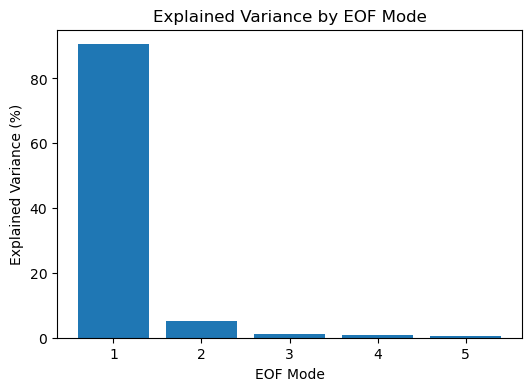

Explained variance ratio: [0.90514326 0.05171032 0.01269847 0.00803157 0.00410716]
[[ 1.00000000e+00 -8.00774075e-18]
 [-8.00774075e-18  1.00000000e+00]]


In [64]:
# Flatten spatial + variable dims
X_flat = X.reshape(time_len, -1)
print("X_flat shape:", X_flat.shape)

# --- PCA analysis ---
pca = PCA(n_components=5)
pcs = pca.fit_transform(X_flat)
eofs = pca.components_
explained_var = pca.explained_variance_ratio_
print(explained_var)

plt.figure(figsize=(6, 4))
plt.bar(range(1, 6), explained_var * 100)
plt.xlabel("EOF Mode")
plt.ylabel("Explained Variance (%)")
plt.title("Explained Variance by EOF Mode")
plt.show()
print("Explained variance ratio:", explained_var)
print(np.corrcoef(pcs[:, 0], pcs[:, 1]))


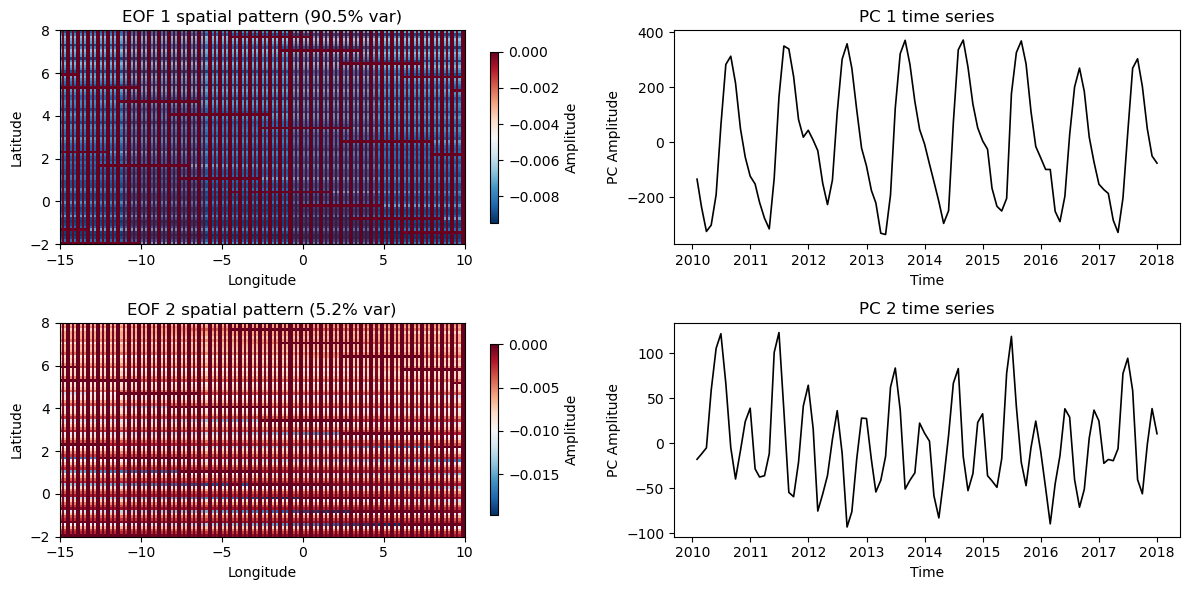

In [65]:
# --- Step 10: visualize first 2 EOFs correctly ---

n_modes_to_plot = 2
fig, axes = plt.subplots(n_modes_to_plot, 2, figsize=(12, 6))

# We’ll get lat/lon values from combined (not stacked)
lat = combined['lat'].values
lon = combined['lon'].values
ny, nx = len(lat), len(lon)

for i in range(n_modes_to_plot):
    # Each EOF is a flattened spatial pattern — reshape to (ny, nx)
    eof_i = eofs[i, :ny * nx].reshape(ny, nx)

    # --- Spatial pattern ---
    ax = axes[i, 0]
    im = ax.pcolormesh(lon, lat, eof_i, cmap='RdBu_r', shading='auto')
    ax.set_title(f"EOF {i+1} spatial pattern ({explained_var[i]*100:.1f}% var)")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.8, label='Amplitude')

    # --- Time series ---
    ax = axes[i, 1]
    ax.plot(stacked['time'], pcs[:, i], color='black', lw=1.2)
    ax.set_title(f"PC {i+1} time series")
    ax.set_xlabel("Time")
    ax.set_ylabel("PC Amplitude")

plt.tight_layout()
plt.savefig('eof1_eof2_spatial.png', dpi=300)
plt.show()
